In [5]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [6]:
# Initial conditions (from the literature)
N = 2412642-(221+9436+9091+124) #population size

S0 = N - 320 #everyone starts out as susceptible, except for 1 person that is infected
I10 = 300 #1 infected person
I20 = 20
D0 = 0
R0 = 0

# A grid of time points (in days)
t = np.linspace(0, 500, 100) #from day 0 to day 500, generate 100 points

#parameters (from the literature)
alpha1 = 0.262
beta1 = 0.143
gamma1 = 0.00294


alpha2 = 0.291
beta2 = 0.143
gamma2 = 0.00194

In [7]:
# The SIDR model differential equations.
def deriv(y, t, alpha1, beta1, gamma1, alpha2, beta2, gamma2,):
    S, I1, I2, D, R = y
    dSdt = - (alpha1/ N) * S * I1- (alpha2/ N) * S * I2
    dI1dt = (alpha1/ N) * S * I1 - beta1 * I1 - gamma1 * I1
    dI2dt = (alpha2/ N) * S * I2 - beta1 * I2 - gamma1 * I2
    dDdt = gamma1 * I1+ gamma2 * I2
    dRdt = beta1 * I1 + beta2 * I2

    return dSdt, dI1dt, dI2dt, dDdt, dRdt

In [8]:
# Initial conditions vector
y0 = S0, I10, I20, D0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(alpha1, beta1, gamma1, alpha2, beta2, gamma2))
S, I1, I2, D, R = ret.T

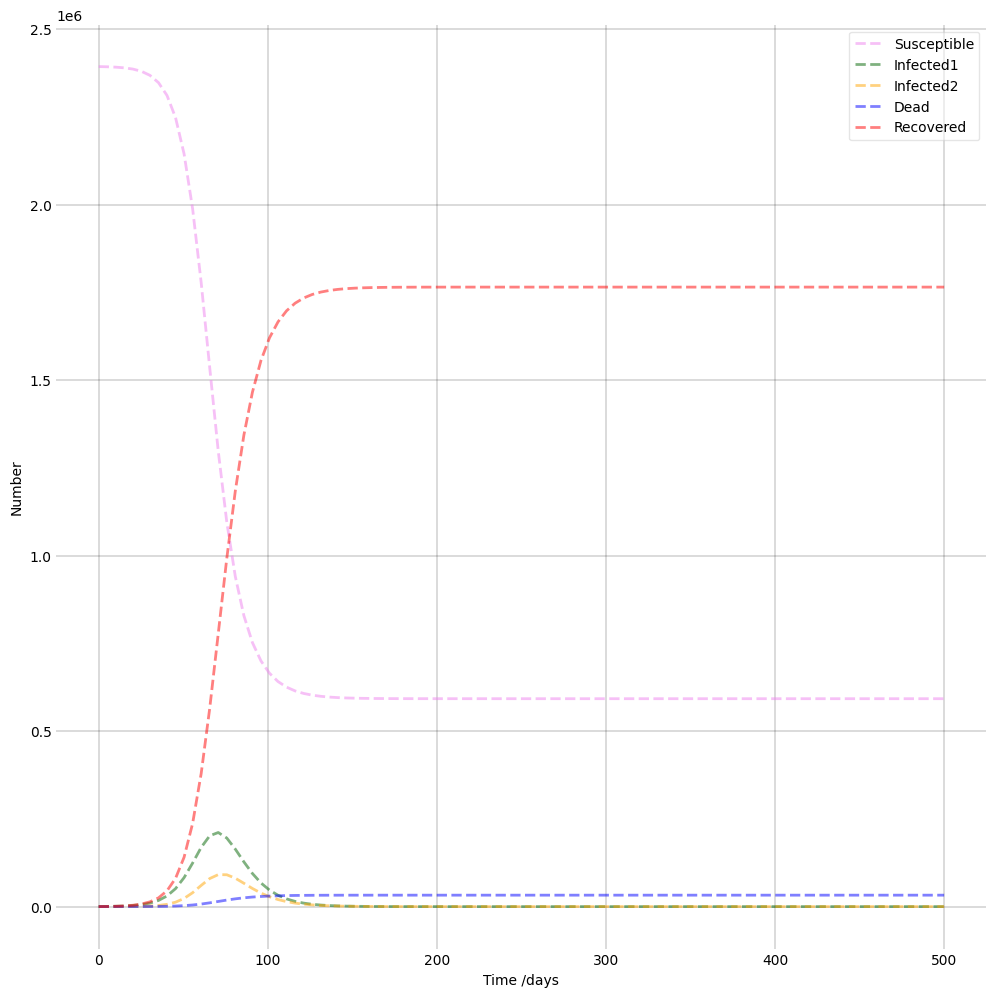

In [9]:
# Plot the data
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

ax.plot(t, S, 'violet', alpha=0.5, lw=2, label='Susceptible', linestyle='dashed')
ax.plot(t, I1, 'darkgreen', alpha=0.5, lw=2, label='Infected1', linestyle='dashed')
ax.plot(t, I2, 'orange', alpha=0.5, lw=2, label='Infected2', linestyle='dashed')
ax.plot(t, D, 'blue', alpha=0.5, lw=2, label='Dead', linestyle='dashed')
ax.plot(t, R, 'red', alpha=0.5, lw=2, label='Recovered', linestyle='dashed')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(visible=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [10]:
#save to csv file
COVID_Data = np.asarray([t, S, I1, I2, D, R]) 
np.savetxt("Covid_practice1.csv", COVID_Data, delimiter=",")

In [11]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [12]:
covid_data = genfromtxt('Covid_practice1.csv', delimiter=',') #in the form of [t,S,I1,I2,D,R]

In [13]:
covid_data

array([[0.00000000e+00, 5.05050505e+00, 1.01010101e+01, 1.51515152e+01,
        2.02020202e+01, 2.52525253e+01, 3.03030303e+01, 3.53535354e+01,
        4.04040404e+01, 4.54545455e+01, 5.05050505e+01, 5.55555556e+01,
        6.06060606e+01, 6.56565657e+01, 7.07070707e+01, 7.57575758e+01,
        8.08080808e+01, 8.58585859e+01, 9.09090909e+01, 9.59595960e+01,
        1.01010101e+02, 1.06060606e+02, 1.11111111e+02, 1.16161616e+02,
        1.21212121e+02, 1.26262626e+02, 1.31313131e+02, 1.36363636e+02,
        1.41414141e+02, 1.46464646e+02, 1.51515152e+02, 1.56565657e+02,
        1.61616162e+02, 1.66666667e+02, 1.71717172e+02, 1.76767677e+02,
        1.81818182e+02, 1.86868687e+02, 1.91919192e+02, 1.96969697e+02,
        2.02020202e+02, 2.07070707e+02, 2.12121212e+02, 2.17171717e+02,
        2.22222222e+02, 2.27272727e+02, 2.32323232e+02, 2.37373737e+02,
        2.42424242e+02, 2.47474747e+02, 2.52525253e+02, 2.57575758e+02,
        2.62626263e+02, 2.67676768e+02, 2.72727273e+02, 2.777777

In [78]:
class DINN(nn.Module):
    def __init__(self, t, S_data, I1_data, I2_data, D_data, R_data): #[t,S,I1, I2,D,R]
        super(DINN, self).__init__()
        
        self.N = 2412642-(221+9436+9091+124) #population size
        
        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 

        #for the compartments we just need to convert them into tensors
        self.S = torch.tensor(S_data)
        self.I1 = torch.tensor(I1_data)
        self.I2 = torch.tensor(I2_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = [] # here I saved the model's losses per epoch

        #setting the parameters
        self.alpha1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta1_tilda = torch.tensor(0.143)
        self.gamma1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))

        self.alpha2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta2_tilda = torch.tensor(0.143)
        self.gamma2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        #find values for normalization
        self.S_max = max(self.S)
        self.I1_max = max(self.I1)
        self.I2_max = max(self.I2)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.I1_min = min(self.I1)
        self.I2_min = min(self.I2)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        #normalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.I1_hat = (self.I1 - self.I1_min) / (self.I1_max - self.I1_min)
        self.I2_hat = (self.I2 - self.I2_min) / (self.I2_max - self.I2_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)        

        #matrices (x4 for S,I1, I2,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 5)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 5)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 5)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 5)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 5)); self.m5[:, 4] = 1

        #NN
        self.net_sidr = self.Net_sidr()
        self.params = list(self.net_sidr.parameters())
        self.params.extend(list([self.alpha1_tilda, self.beta1_tilda, self.gamma1_tilda, self.alpha2_tilda, self.beta2_tilda, self.gamma2_tilda]))

    #force parameters to be in a range
    @property
    def alpha1(self):
        return torch.tanh(self.alpha1_tilda) #* 0.1 + 0.2

    @property
    def beta1(self):
        return torch.tanh(self.beta1_tilda) #* 0.01 + 0.05
    
    @property
    def gamma1(self):
        return torch.tanh(self.gamma1_tilda) #* 0.01 + 0.03
    
    @property
    def alpha2(self):
        return torch.tanh(self.alpha2_tilda) #* 0.1 + 0.2

    @property
    def beta2(self):
        return torch.tanh(self.beta2_tilda) #* 0.01 + 0.05
    
    @property
    def gamma2(self):
        return torch.tanh(self.gamma2_tilda) #* 0.01 + 0.03

    class Net_sidr(nn.Module): # input = [[t1], [t2]...[t100]] -- that is, a batch of timesteps 
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()

            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 5) #outputs S, I1, I2, D, R (100 S, 100 I, 100 D, 100 R --- since we have a batch of 100 timesteps)

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=F.relu(self.fc5(sidr))
            sidr=F.relu(self.fc6(sidr))
            sidr=F.relu(self.fc7(sidr))
            sidr=F.relu(self.fc8(sidr))
            sidr=self.out(sidr)
            return sidr

    def net_f(self, t_batch):
            
            #pass the timesteps batch to the neural network
            sidr_hat = self.net_sidr(t_batch)
            print(self.params[0])
            #organize S,I,D,R from the neural network's output -- note that these are normalized values -- hence the "hat" part
            S_hat, I1_hat, I2_hat, D_hat, R_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2], sidr_hat[:,3], sidr_hat[:,4]

            #S_t
            sidr_hat.backward(self.m1, retain_graph=True)
            S_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #I1_t
            sidr_hat.backward(self.m2, retain_graph=True)
            I1_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #I2_t
            sidr_hat.backward(self.m3, retain_graph=True)
            I2_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #D_t
            sidr_hat.backward(self.m4, retain_graph=True)
            D_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #R_t
            sidr_hat.backward(self.m5, retain_graph=True)
            R_hat_t = self.t.grad.clone()
            self.t.grad.zero_() 

            #unnormalize
            S = self.S_min + (self.S_max - self.S_min) * S_hat
            I1 = self.I1_min + (self.I1_max - self.I1_min) * I1_hat
            I2 = self.I2_min + (self.I2_max - self.I2_min) * I2_hat
            D = self.D_min + (self.D_max - self.D_min) * D_hat      
            R = self.R_min + (self.R_max - self.R_min) * R_hat        

            f1_hat = S_hat_t - (-(self.alpha1 / self.N) * S * I1 -(self.alpha2 / self.N) * S * I2 )  / (self.S_max - self.S_min)
            f2_hat = I1_hat_t - ((self.alpha1 / self.N) * S * I1 - self.beta1 * I1 - self.gamma1 * I1 ) / (self.I1_max - self.I1_min)
            f3_hat = I2_hat_t - ((self.alpha2 / self.N) * S * I2 - self.beta2 * I2 - self.gamma2 * I2 ) / (self.I2_max - self.I2_min)
            f4_hat = D_hat_t - (self.gamma1 * I1 + self.gamma2 * I2) / (self.D_max - self.D_min)
            f5_hat = R_hat_t - (self.beta1 * I1 + self.beta2 * I2) / (self.R_max - self.R_min)        

            return f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, S_hat, I1_hat, I2_hat, D_hat, R_hat
    def train(self, n_epochs):
        # train
        print('\nstarting training...\n')
        
        for epoch in range(n_epochs):
            # lists to hold the output (maintain only the final epoch)
            S_pred_list = []
            I1_pred_list = []
            I2_pred_list = []
            D_pred_list = []
            R_pred_list = []

            # we pass the timesteps batch into net_f
            f1, f2, f3, f4, f5, S_pred, I1_pred, I2_pred, D_pred, R_pred = self.net_f(self.t_batch) # net_f outputs f1_hat, f2_hat, f3_hat, f4_hat, S_hat, I_hat, D_hat, R_hat
            
            self.optimizer.zero_grad() #zero grad
            
            #append the values to plot later (note that we unnormalize them here for plotting)
            S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_pred)
            I1_pred_list.append(self.I1_min + (self.I1_max - self.I1_min) * I1_pred)
            I2_pred_list.append(self.I2_min + (self.I2_max - self.I2_min) * I2_pred)
            D_pred_list.append(self.D_min + (self.D_max - self.D_min) * D_pred)
            R_pred_list.append(self.R_min + (self.R_max - self.R_min) * R_pred)

            #calculate the loss --- MSE of the neural networks output and each compartment
            loss = (torch.mean(torch.square(self.S_hat - S_pred))+ 
                    torch.mean(torch.square(self.I1_hat - I1_pred))+
                    torch.mean(torch.square(self.I2_hat - I2_pred))+
                    torch.mean(torch.square(self.D_hat - D_pred))+
                    torch.mean(torch.square(self.R_hat - R_pred))+
                    torch.mean(torch.square(f1))+
                    torch.mean(torch.square(f2))+
                    torch.mean(torch.square(f3))+
                    torch.mean(torch.square(f4))+
                    torch.mean(torch.square(f5))
                    ) 

            loss.backward()
            self.optimizer.step()
            self.scheduler.step() 

            # append the loss value (we call "loss.item()" because we just want the value of the loss and not the entire computational graph)
            self.losses.append(loss.item())
            
            #if epoch % 10 == 0:          
                #print('\nEpoch ', epoch)

                #print('alpha1: (goal 0.262 ', self.alpha1)
                #print('beta1: (goal 0.05 ', self.beta1)
                #print('gamm1: (goal 0.0294 ', self.gamma1)

                #print('alpha2: (goal 0.291 ', self.alpha2)
                #print('beta2: (goal 0.045 ', self.beta2)
                #print('gamma2: (goal 0.0194 ', self.gamma2)

                #print('#################################')                
            
        return S_pred_list, I1_pred_list, I2_pred_list, D_pred_list, R_pred_list
    

In [79]:
%%time
dinn = DINN(covid_data[0], covid_data[1], covid_data[2], covid_data[3], 
            covid_data[4], covid_data[5]) #in the form of [t,S,I1,I2,D,R]
learning_rate = 1e-6
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer
scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=1000, mode="exp_range", gamma=0.85, cycle_momentum=False)
dinn.scheduler = scheduler
S_pred_list, I1_pred_list, I2_pred_list, D_pred_list, R_pred_list = dinn.train(5) #train


starting training...

Parameter containing:
tensor([[ 0.6982],
        [ 0.1870],
        [-0.0950],
        [ 0.7609],
        [-0.0740],
        [-0.3538],
        [ 0.5771],
        [ 0.5200],
        [-0.4743],
        [ 0.2967],
        [ 0.0568],
        [ 0.5824],
        [ 0.0991],
        [-0.2455],
        [ 0.4496],
        [-0.0394],
        [ 0.7341],
        [ 0.2723],
        [ 0.0582],
        [-0.5758]], requires_grad=True)
Parameter containing:
tensor([[ 0.6982],
        [ 0.1870],
        [-0.0950],
        [ 0.7609],
        [-0.0740],
        [-0.3538],
        [ 0.5771],
        [ 0.5200],
        [-0.4743],
        [ 0.2966],
        [ 0.0568],
        [ 0.5824],
        [ 0.0991],
        [-0.2455],
        [ 0.4496],
        [-0.0394],
        [ 0.7341],
        [ 0.2723],
        [ 0.0582],
        [-0.5758]], requires_grad=True)
Parameter containing:
tensor([[ 0.6982],
        [ 0.1870],
        [-0.0950],
        [ 0.7609],
        [-0.0740],
        [-0.35

Text(0, 0.5, 'Loss')

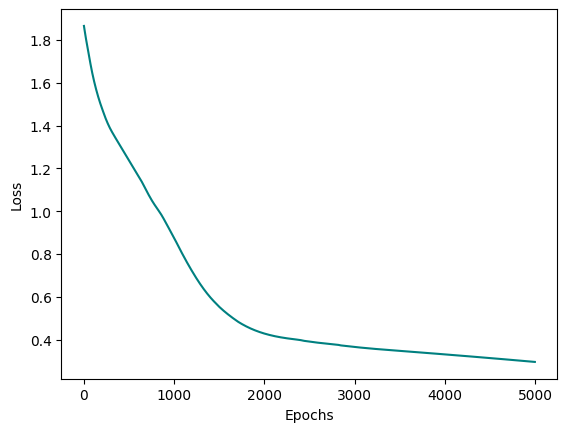

In [23]:
plt.plot(dinn.losses[0:], color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss')

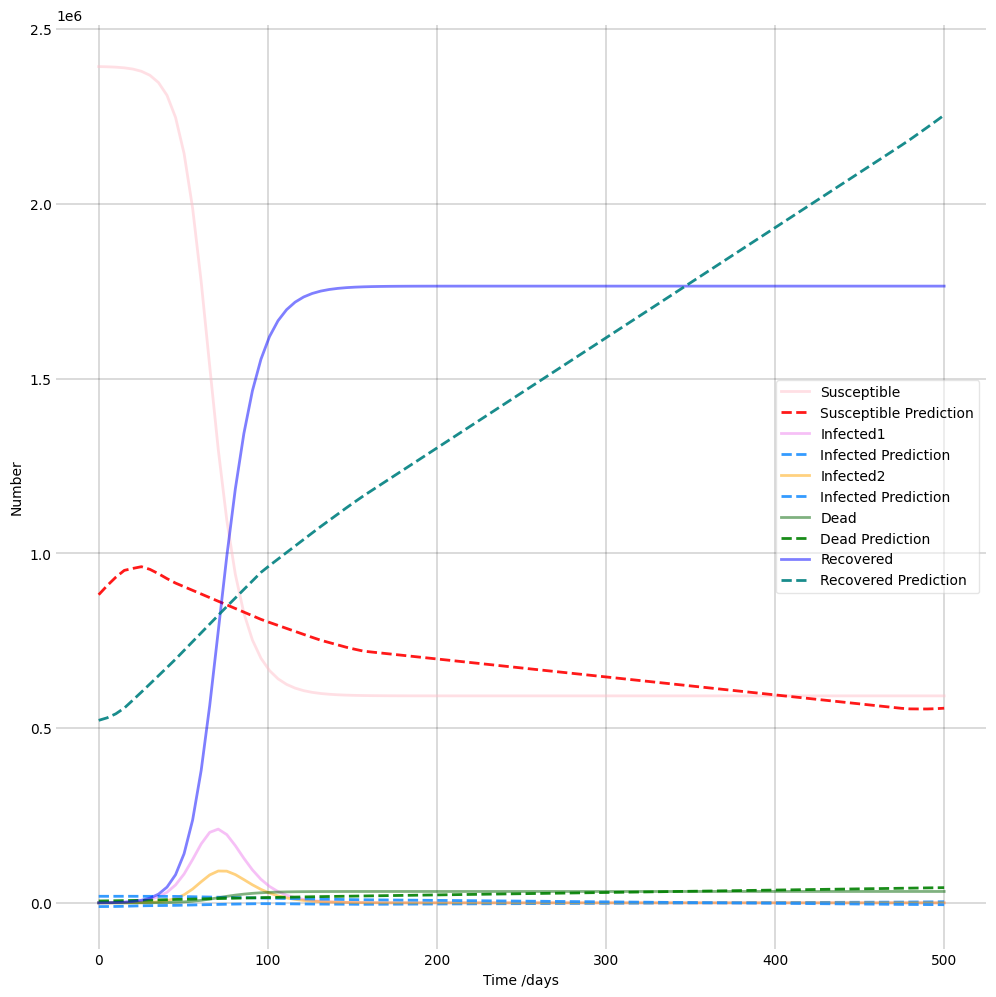

In [24]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

ax.plot(covid_data[0], covid_data[1], 'pink', alpha=0.5, lw=2, label='Susceptible')
ax.plot(covid_data[0], S_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Susceptible Prediction', linestyle='dashed')

ax.plot(covid_data[0], covid_data[2], 'violet', alpha=0.5, lw=2, label='Infected1')
ax.plot(covid_data[0], I1_pred_list[0].detach().numpy(), 'dodgerblue', alpha=0.9, lw=2, label='Infected Prediction', linestyle='dashed')

ax.plot(covid_data[0], covid_data[3], 'orange', alpha=0.5, lw=2, label='Infected2')
ax.plot(covid_data[0], I2_pred_list[0].detach().numpy(), 'dodgerblue', alpha=0.9, lw=2, label='Infected Prediction', linestyle='dashed')


ax.plot(covid_data[0], covid_data[4], 'darkgreen', alpha=0.5, lw=2, label='Dead')
ax.plot(covid_data[0], D_pred_list[0].detach().numpy(), 'green', alpha=0.9, lw=2, label='Dead Prediction', linestyle='dashed')

ax.plot(covid_data[0], covid_data[5], 'blue', alpha=0.5, lw=2, label='Recovered')
ax.plot(covid_data[0], R_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=2, label='Recovered Prediction', linestyle='dashed')

  
ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(visible=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()